# 1. 30G data

## 1.1. 探索性分析

### 1.1.1. 基础信息

In [5]:
%%time
import os
import pandas as pd
from pathlib import Path

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import gc
import matplotlib.font_manager as fm
from collections import defaultdict
font_path = 'C:/Windows/Fonts/msyh.ttc'
font_prop = fm.FontProperties(fname=font_path)

# # 设置中文字体
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

CPU times: total: 15.6 ms
Wall time: 43 ms


In [6]:
# 读取parquet数据集
data_dir = Path("F:\postgraduate\课程\研一下\数据挖掘\\torrents\\new\\30G_data_new")
parquet_files = [file for file in data_dir.glob("*.parquet")]

In [7]:
%%time
total_rows = 0
total_columns = 0

for file in parquet_files:
    sample = pd.read_parquet(file, engine='pyarrow')
    if total_columns == 0:
        total_columns = len(sample.columns)
        column_info = sample.dtypes
    del sample
    gc.collect()
    
    import pyarrow.parquet as pq
    file_rows = pq.read_metadata(file).num_rows
    total_rows += file_rows
    del file_rows
    gc.collect()
    

print(f"总数据量: {total_rows} 行 × {total_columns} 列")

# 展示数据类型概览
print("\n数据类型概览:")
print(column_info)

总数据量: 135000000 行 × 15 列

数据类型概览:
id                     int64
last_login            object
user_name             object
fullname              object
email                 object
age                    int64
income               float64
gender                object
country               object
address               object
purchase_history      object
is_active               bool
registration_date     object
phone_number          object
login_history         object
dtype: object
CPU times: total: 23min 55s
Wall time: 26min


```markdown
数据集的基本信息如下：
- 总行数：13500万行
- 总列数：15列
- 数据类型分布：
    - 整型(int64)：2列 (id, age)
    - 浮点型(float64)：1列 (income)
    - 布尔型(bool)：1列 (is_active)
    - 对象型(object)：11列 (last_login, user_name等)
```

In [8]:
%%time
# 显示前5行数据
df = pd.read_parquet(parquet_files[0], engine='pyarrow')
print(df.head())
del df
gc.collect()

   id                 last_login   user_name fullname               email  \
0   0  2024-03-19T19:35:16+00:00  OFVIUGZMWH      覃泽川  lnsqjypb@gmail.com   
1   1  2025-02-21T05:08:16+00:00      KMLBNE      吕泽越     zddfsdkt@qq.com   
2   2  2024-11-26T09:33:05+00:00     NGTSMVK      卞泽楠    qxgqdrfd@163.com   
3   3  2023-10-19T17:32:56+00:00      IJLZVS       卞鹏    jbjxirrf@163.com   
4   4  2024-05-09T00:01:29+00:00       XCLES       郎雪     cnerwras@qq.com   

   age     income gender country                          address  \
0   97    7787.23      女      日本                   西藏自治区鹤岗河滨路827号   
1   31  286306.19      男      美国  Non-Chinese Address Placeholder   
2   82  136343.81      男      日本                    重庆市保定检察院路503号   
3   90  179801.85      男      印度                   江西省南京儿童乐园路510号   
4   73  918006.25      女      英国                   福建省南宁技术学院路988号   

                                    purchase_history  is_active  \
0  {"avg_price":4041,"categories":"文具","items":[{...   

0

### 1.1.2. 数据统计

In [9]:
%%time
df = pd.read_parquet(parquet_files[0], engine='pyarrow')
num_fields = df.select_dtypes(include=np.number).columns.values
nom_fields = df.select_dtypes(exclude=np.number).columns.values
print('标称属性:', nom_fields)
print('数值属性:', num_fields)

标称属性: ['last_login' 'user_name' 'fullname' 'email' 'gender' 'country' 'address'
 'purchase_history' 'is_active' 'registration_date' 'phone_number'
 'login_history']
数值属性: ['id' 'age' 'income']
CPU times: total: 1min 49s
Wall time: 2min 8s


In [10]:
%%time
# 统计标称属性数据分布情况
# 以“country”属性为例，进行频数统计
count_columns = ['country']
field = 'country'
country_counter = Counter()

for file in parquet_files:
    df = pd.read_parquet(file, columns=count_columns, engine='pyarrow')

    if field in df.columns:
        file_countries = Counter(df[field].fillna('Unknown'))
        country_counter.update(file_countries)
    
    del df
    gc.collect()

most_common = country_counter.most_common(10)
for country, count in most_common:
    print(f"{country}: {count}")

total = sum(country_counter.values())
print('\n百分比统计:')
for country, count in most_common:
    percentage = (count/total) * 100
    print(f"{country}: {count} ({percentage:.2f}%)")

澳大利亚: 13502953
印度: 13502855
美国: 13502589
俄罗斯: 13500996
法国: 13499078
日本: 13498944
中国: 13498904
巴西: 13498665
英国: 13498183
德国: 13496833

百分比统计:
澳大利亚: 13502953 (10.00%)
印度: 13502855 (10.00%)
美国: 13502589 (10.00%)
俄罗斯: 13500996 (10.00%)
法国: 13499078 (10.00%)
日本: 13498944 (10.00%)
中国: 13498904 (10.00%)
巴西: 13498665 (10.00%)
英国: 13498183 (10.00%)
德国: 13496833 (10.00%)
CPU times: total: 36.5 s
Wall time: 35.1 s


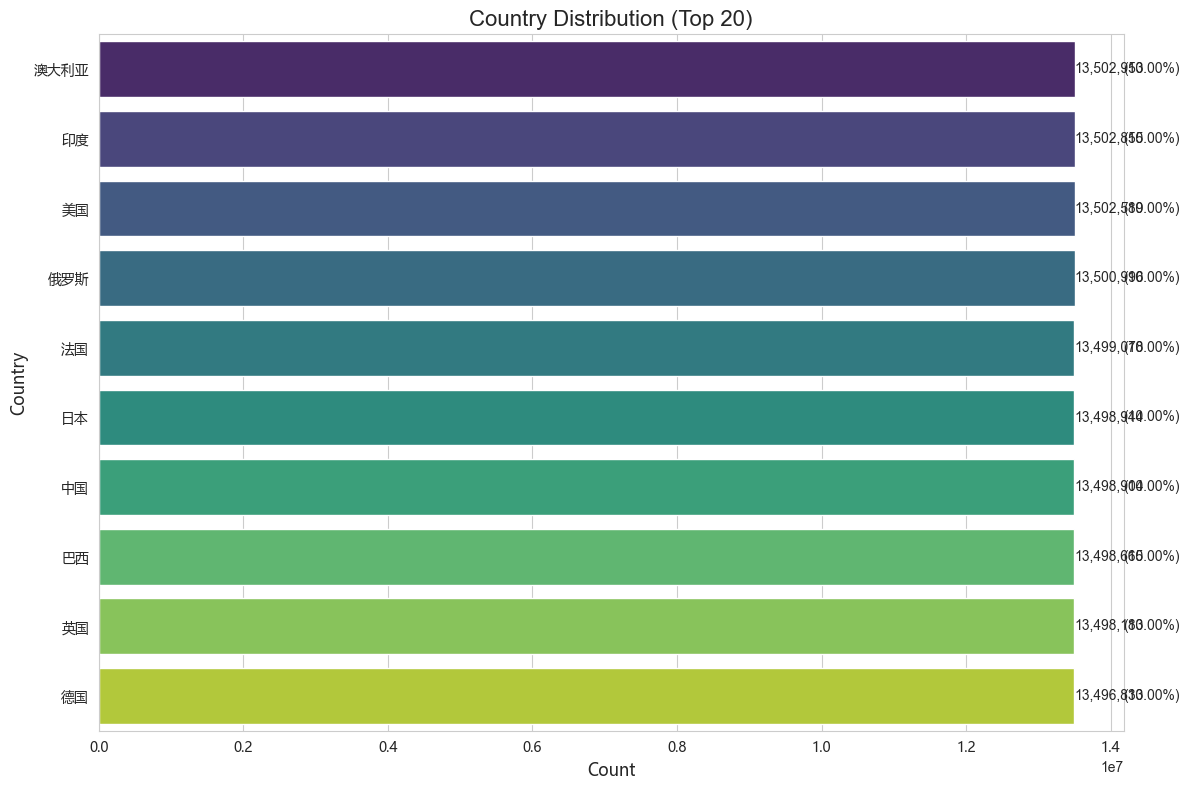

CPU times: total: 375 ms
Wall time: 452 ms


In [11]:
%%time
country_df = pd.DataFrame({
    'Country': list(country_counter.keys()),
    'Count': list(country_counter.values())
})

country_df = country_df.sort_values('Count', ascending=False)

top_countries = country_df.head(20)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

ax = sns.barplot(x='Count', y='Country', data=top_countries, palette='viridis')

for i, v in enumerate(top_countries['Count']):
    ax.text(v + 0.1, i, f"{v:,}", va='center')

total = sum(country_counter.values())
for i, (_, row) in enumerate(top_countries.iterrows()):
    percentage = (row['Count'] / total) * 100
    ax.text(row['Count'] + max(top_countries['Count'])*0.05, i, f"({percentage:.2f}%)", va='center')

plt.title('Country Distribution (Top 20)', fontsize=16)
plt.xlabel('Count', fontsize=12, fontproperties=font_prop)
plt.ylabel('Country', fontsize=12, fontproperties=font_prop)

plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)

plt.tight_layout()
plt.show()

In [12]:
%%time
# 以第一个文件为例，查看数值属性数据分布情况
df = pd.read_parquet(parquet_files[0], engine='pyarrow')
df.describe()

CPU times: total: 1min 17s
Wall time: 1min 17s


,id,age,income
count,8.437500e+06,8.437500e+06,8.437500e+06
mean,4.218750e+06,5.901106e+01,4.999035e+05
std,2.435697e+06,2.395160e+01,2.887141e+05
min,0.000000e+00,1.800000e+01,2.000000e-02
25%,2.109375e+06,3.800000e+01,2.498230e+05
50%,4.218750e+06,5.900000e+01,4.998886e+05
75%,6.328124e+06,8.000000e+01,7.499773e+05
max,8.437499e+06,1.000000e+02,1.000000e+06


## 1.2. 数据分析及可视化

### 1.2.1. 标称属性

In [13]:
%%time
# 展示性别分布、邮箱域名分布
count_columns = ['gender', 'email']

gender_counter = Counter()
email_domain_counter = Counter()

for file in tqdm.tqdm(parquet_files):
    df = pd.read_parquet(file, columns=count_columns, engine='pyarrow')
    
    gender_counts = Counter(df['gender'].fillna('Unknown'))
    gender_counter.update(gender_counts)
    
    if 'email' in df.columns:
        domains = df['email'].fillna('').apply(lambda x: x.split('@')[-1] if '@' in x else 'Invalid')
        domain_counts = Counter(domains)
        email_domain_counter.update(domain_counts)
    
    del df
    gc.collect()

total_gender = sum(gender_counter.values())
total_emails = sum(email_domain_counter.values())

100%|██████████| 16/16 [02:44<00:00, 10.28s/it]

CPU times: total: 2min 47s
Wall time: 2min 44s


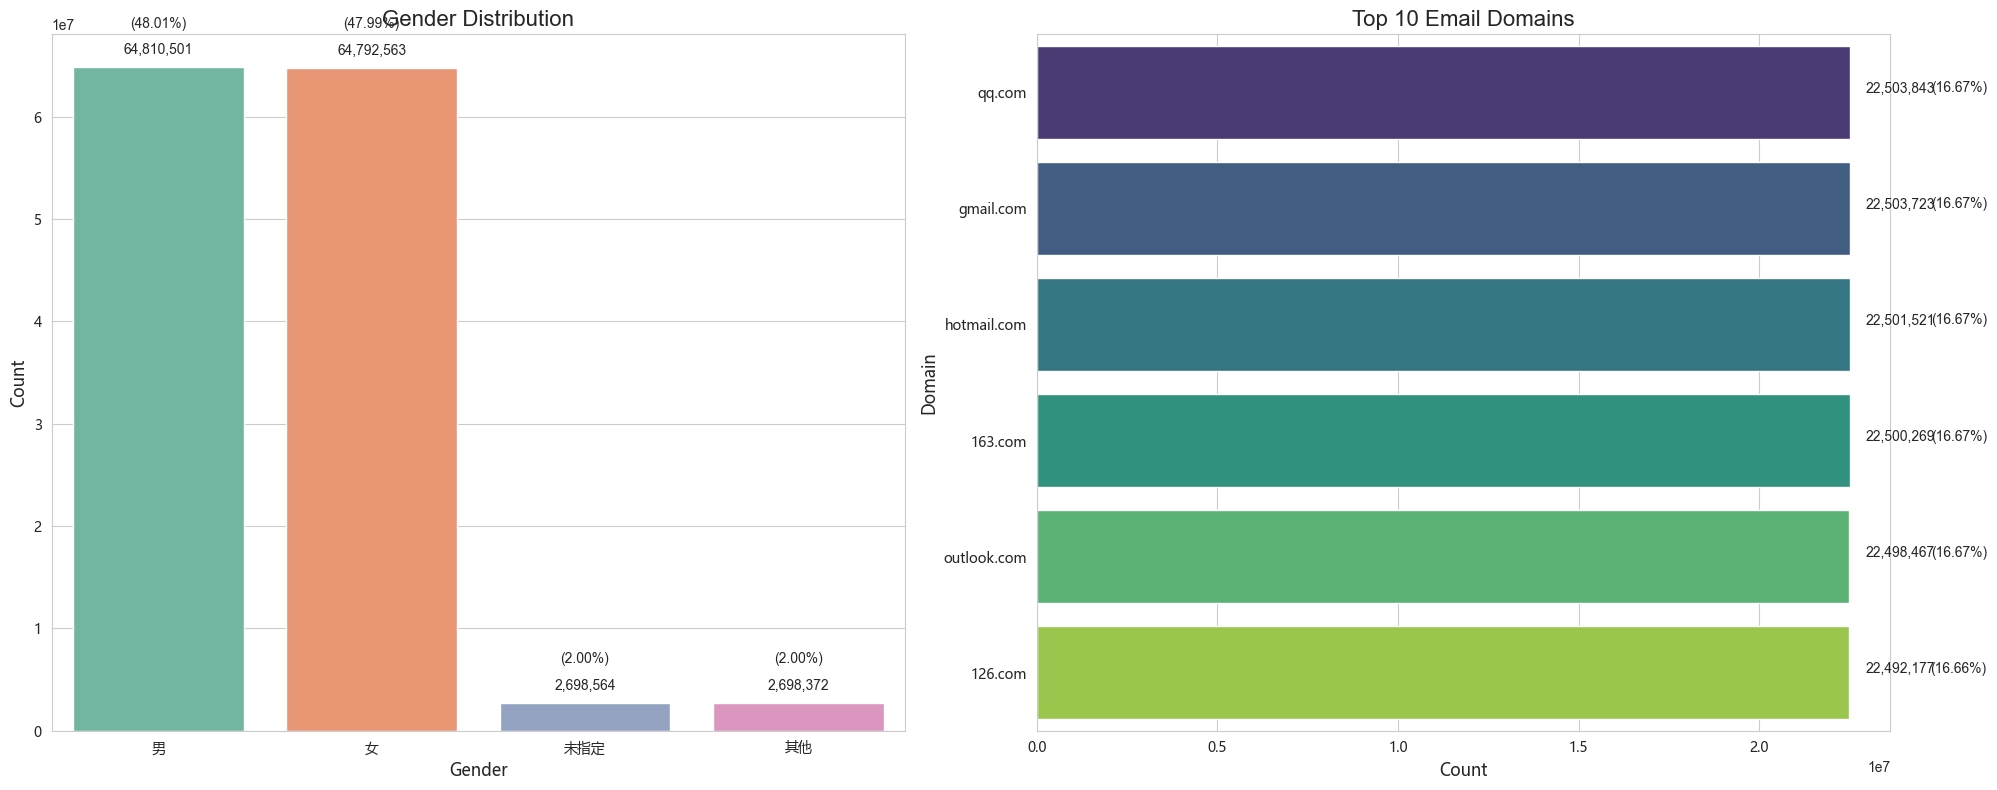

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# 1. 性别分布图
gender_df = pd.DataFrame({
    'Gender': list(gender_counter.keys()),
    'Count': list(gender_counter.values())
})
gender_df = gender_df.sort_values('Count', ascending=False)

sns.barplot(x='Gender', y='Count', data=gender_df, ax=axs[0], palette='Set2')
axs[0].set_title('Gender Distribution', fontsize=16)
axs[0].set_xlabel('Gender', fontsize=12, fontproperties=font_prop)
axs[0].set_ylabel('Count', fontsize=12, fontproperties=font_prop)

for label in axs[0].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[0].get_yticklabels():
    label.set_fontproperties(font_prop)

for i, v in enumerate(gender_df['Count']):
    percentage = (v / total_gender) * 100
    axs[0].text(i, v + max(gender_df['Count'])*0.02, f"{v:,}", ha='center')
    axs[0].text(i, v + max(gender_df['Count'])*0.06, f"({percentage:.2f}%)", ha='center')

# 2. 邮箱域名分布图（仅显示前10个）
top_domains = dict(email_domain_counter.most_common(10))
domain_df = pd.DataFrame({
    'Domain': list(top_domains.keys()),
    'Count': list(top_domains.values())
})

sns.barplot(x='Count', y='Domain', data=domain_df, ax=axs[1], palette='viridis')
axs[1].set_title('Top 10 Email Domains', fontsize=16)
axs[1].set_xlabel('Count', fontsize=12, fontproperties=font_prop)
axs[1].set_ylabel('Domain', fontsize=12, fontproperties=font_prop)

for label in axs[1].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[1].get_yticklabels():
    label.set_fontproperties(font_prop)

for i, v in enumerate(domain_df['Count']):
    percentage = (v / total_emails) * 100
    axs[1].text(v + max(domain_df['Count'])*0.02, i, f"{v:,}")
    axs[1].text(v + max(domain_df['Count'])*0.10, i, f"({percentage:.2f}%)")

plt.tight_layout()
plt.show()

In [15]:
# 打印详细统计结果
print("\n性别分布统计:")
for gender, count in gender_counter.most_common():
    percentage = (count / total_gender) * 100
    print(f"{gender}: {count:,} ({percentage:.2f}%)")

print("\n邮箱域名分布统计 (前10):")
for domain, count in email_domain_counter.most_common(10):
    percentage = (count / total_emails) * 100
    print(f"{domain}: {count:,} ({percentage:.2f}%)")


性别分布统计:
男: 64,810,501 (48.01%)
女: 64,792,563 (47.99%)
未指定: 2,698,564 (2.00%)
其他: 2,698,372 (2.00%)

邮箱域名分布统计 (前10):
qq.com: 22,503,843 (16.67%)
gmail.com: 22,503,723 (16.67%)
hotmail.com: 22,501,521 (16.67%)
163.com: 22,500,269 (16.67%)
outlook.com: 22,498,467 (16.67%)
126.com: 22,492,177 (16.66%)


### 1.2.2. 数值属性

In [16]:
%%time
# 数据分布可视化，包括年龄、收入
count_columns = ['age', 'income']

age_counter = Counter()
income_stats = {
    'sum': 0,
    'count': 0,
    'values': []
}

# 采样收入值
income_sample_rate = 0.01

for file in tqdm.tqdm(parquet_files):
    df = pd.read_parquet(file, columns=count_columns, engine='pyarrow')
    
    age_counts = Counter(df['age'].fillna(-1))
    age_counter.update(age_counts)
    
    valid_income = df['income'].dropna()
    income_stats['sum'] += valid_income.sum()
    income_stats['count'] += len(valid_income)
    
    if len(income_stats['values']) < 100000:
        income_sample = valid_income.sample(frac=income_sample_rate)
        income_stats['values'].extend(income_sample.tolist())
    
    del df
    gc.collect()

100%|██████████| 16/16 [00:21<00:00,  1.32s/it]

CPU times: total: 22.7 s
Wall time: 21.1 s



年龄统计信息:
年龄范围: 18 - 100
最常见年龄 (Top 5): 27: 1,629,722, 100: 1,629,290, 73: 1,629,212, 55: 1,629,182, 49: 1,628,789

收入统计信息:
平均收入: 500031.76
收入中位数: 499613.76
收入标准差: 288241.22


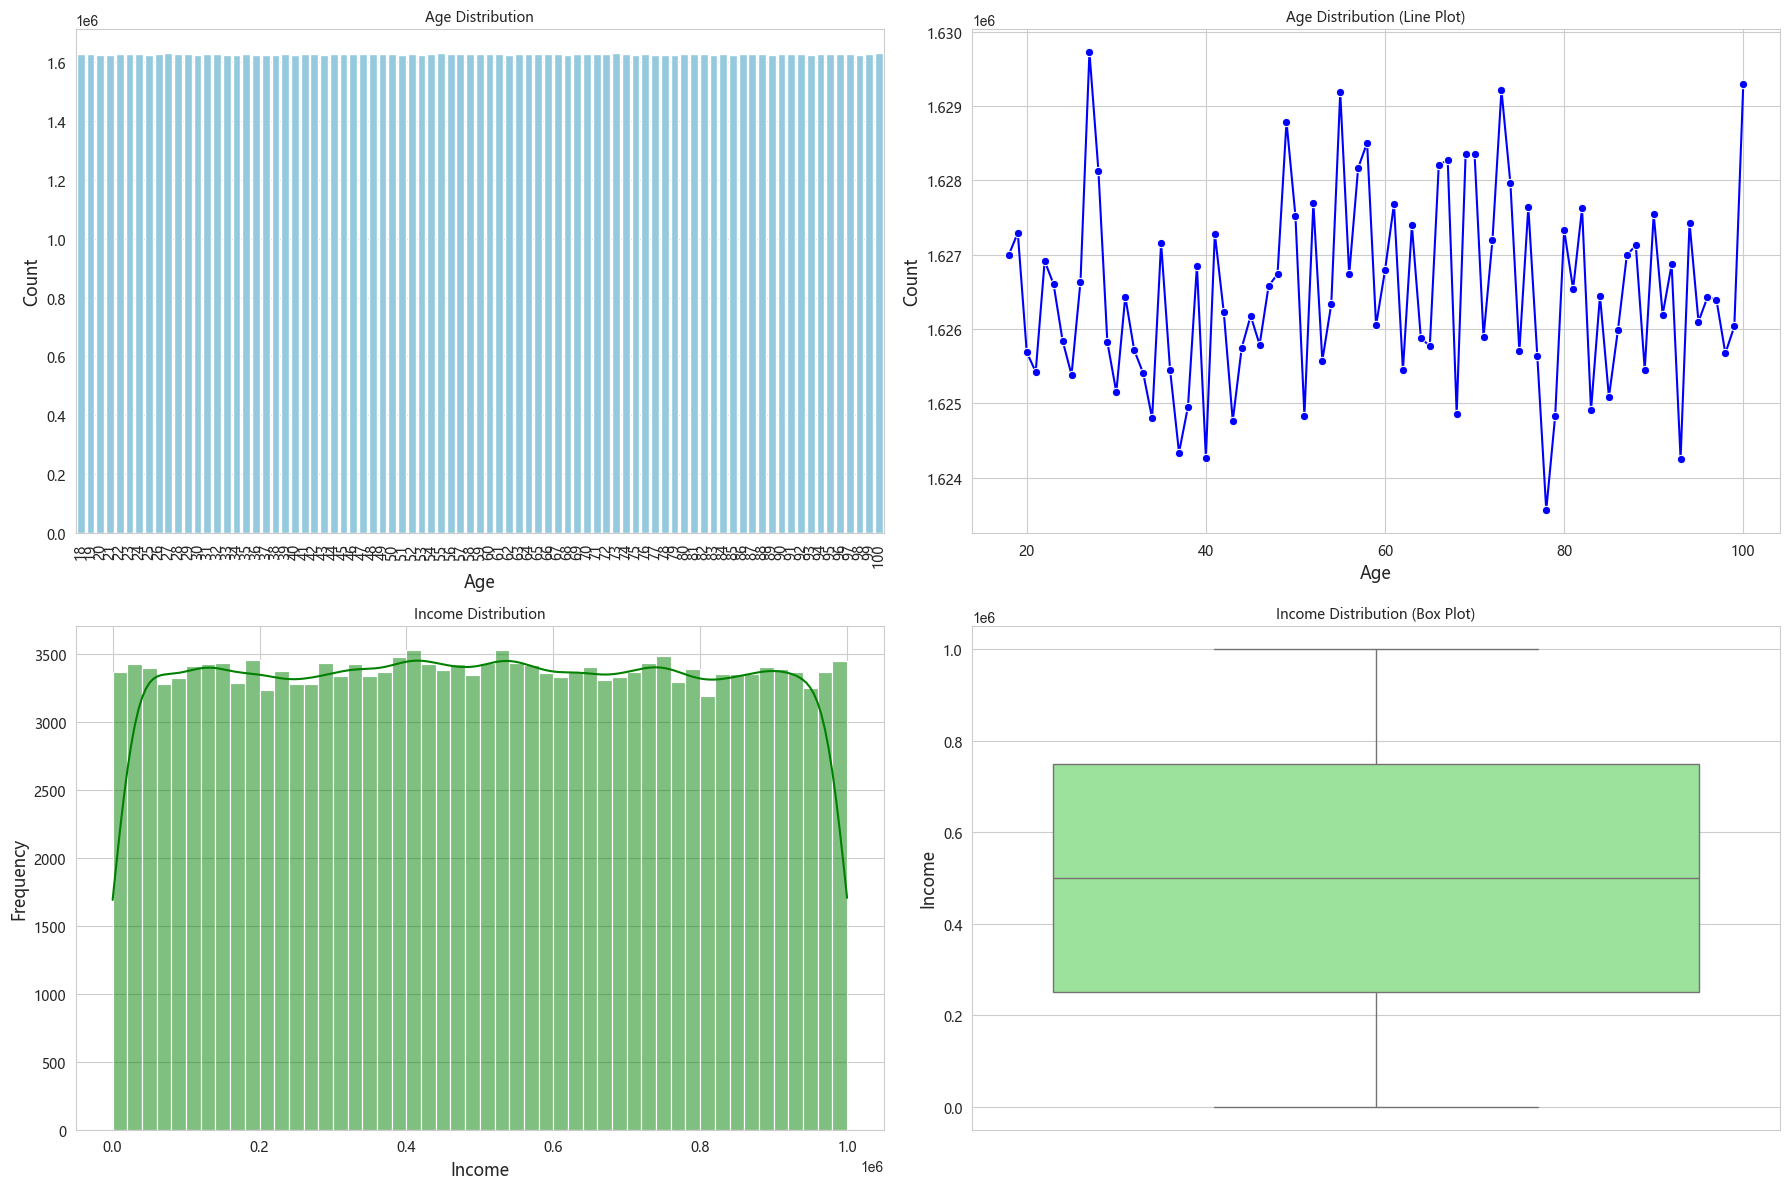

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# 1. 年龄分布 - 柱状图
age_df = pd.DataFrame({
    'Age': list(age_counter.keys()),
    'Count': list(age_counter.values())
})
age_df = age_df[age_df['Age'] >= 0]
age_df = age_df.sort_values('Age')

sns.barplot(x='Age', y='Count', data=age_df, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Age Distribution', fontsize=14, fontproperties=font_prop)
axs[0, 0].set_xlabel('Age', fontsize=12, fontproperties=font_prop)
axs[0, 0].set_ylabel('Count', fontsize=12, fontproperties=font_prop)
axs[0, 0].tick_params(axis='x', rotation=90)

for label in axs[0, 0].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[0, 0].get_yticklabels():
    label.set_fontproperties(font_prop)

# 2. 年龄分布 - 折线图
sns.lineplot(x='Age', y='Count', data=age_df, ax=axs[0, 1], color='blue', marker='o')
axs[0, 1].set_title('Age Distribution (Line Plot)', fontsize=14, fontproperties=font_prop)
axs[0, 1].set_xlabel('Age', fontsize=12, fontproperties=font_prop)
axs[0, 1].set_ylabel('Count', fontsize=12, fontproperties=font_prop)

for label in axs[0, 1].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[0, 1].get_yticklabels():
    label.set_fontproperties(font_prop)

# 3. 收入分布 - 直方图
income_array = np.array(income_stats['values'])
sns.histplot(income_array, bins=50, kde=True, ax=axs[1, 0], color='green')
axs[1, 0].set_title('Income Distribution', fontsize=14, fontproperties=font_prop)
axs[1, 0].set_xlabel('Income', fontsize=12, fontproperties=font_prop)
axs[1, 0].set_ylabel('Frequency', fontsize=12, fontproperties=font_prop)

for label in axs[1, 0].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[1, 0].get_yticklabels():
    label.set_fontproperties(font_prop)

# 4. 收入分布 - 箱形图
sns.boxplot(y=income_array, ax=axs[1, 1], color='lightgreen')
axs[1, 1].set_title('Income Distribution (Box Plot)', fontsize=14, fontproperties=font_prop)
axs[1, 1].set_ylabel('Income', fontsize=12, fontproperties=font_prop)

for label in axs[1, 1].get_xticklabels():
    label.set_fontproperties(font_prop)
for label in axs[1, 1].get_yticklabels():
    label.set_fontproperties(font_prop)

print("\n年龄统计信息:")
print(f"年龄范围: {min(age_df['Age'])} - {max(age_df['Age'])}")
print(f"最常见年龄 (Top 5): {', '.join([f'{age}: {count:,}' for age, count in age_counter.most_common(5)])}")

print("\n收入统计信息:")
avg_income = income_stats['sum'] / income_stats['count']
print(f"平均收入: {avg_income:.2f}")
print(f"收入中位数: {np.median(income_array):.2f}")
print(f"收入标准差: {np.std(income_array):.2f}")

plt.tight_layout()
plt.show()

## 1.3. 数据预处理

### 1.3.1. 缺失值统计处理

In [18]:
%%time
# 针对数值属性的缺失值可视化，绘制条形图
num_cols = ['age', 'income']
missing_data = {}

for col in num_cols:
    missing_data[col] = {'count': 0, 'total': 0}

for file in tqdm.tqdm(parquet_files):
    df = pd.read_parquet(file, columns= num_cols,engine='pyarrow')
    for col in num_cols:
        if col in df.columns:
            missing = df[col].isna().sum()
            total = len(df)
            missing_data[col]['count'] += missing
            missing_data[col]['total'] += total
    del df
    gc.collect()

for col in missing_data:
    missing_data[col]['percentage'] = (missing_data[col]['count'] / missing_data[col]['total']) * 100

100%|██████████| 16/16 [00:03<00:00,  4.46it/s]

CPU times: total: 5.88 s
Wall time: 3.59 s


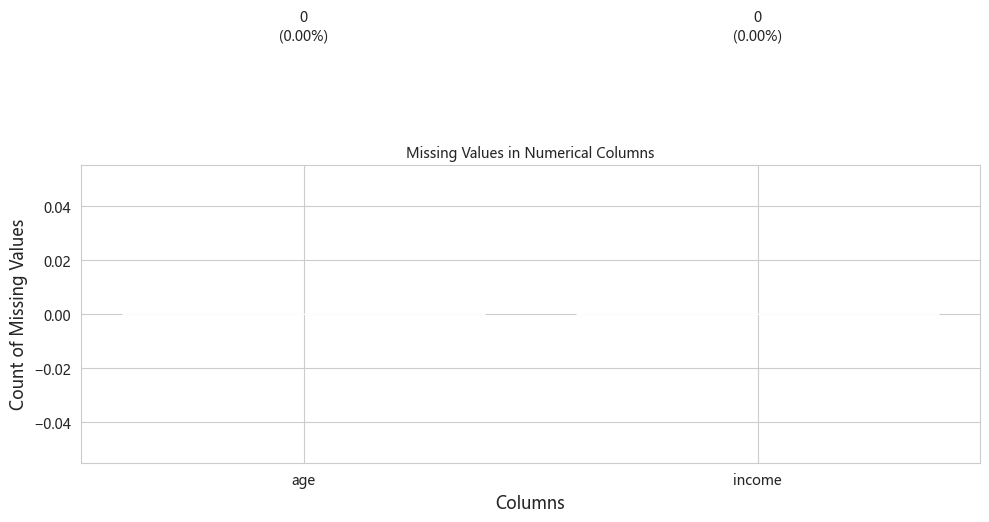


缺失值统计:
age: 0 个缺失值，占比 0.00%
income: 0 个缺失值，占比 0.00%


In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

columns = list(missing_data.keys())
missing_counts = [missing_data[col]['count'] for col in columns]
missing_percentages = [missing_data[col]['percentage'] for col in columns]

bars = ax.bar(columns, missing_counts, color='skyblue')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{missing_counts[i]:,}\n({missing_percentages[i]:.2f}%)',
            ha='center', va='bottom', fontproperties=font_prop)

ax.set_title('Missing Values in Numerical Columns', fontsize=14, fontproperties=font_prop)
ax.set_xlabel('Columns', fontsize=12, fontproperties=font_prop)
ax.set_ylabel('Count of Missing Values', fontsize=12, fontproperties=font_prop)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
for label in ax.get_yticklabels():
    label.set_fontproperties(font_prop)

plt.tight_layout()
plt.show()

print("\n缺失值统计:")
for col in missing_data:
    print(f"{col}: {missing_data[col]['count']:,} 个缺失值，占比 {missing_data[col]['percentage']:.2f}%")


### 1.3.2. 异常值统计处理

In [20]:
%%time
# 对数值属性进行异常值统计
num_cols = ['age', 'income']

outlier_stats = {col: {'total_count': 0, 'outlier_count': 0, 'min': float('inf'), 'max': float('-inf')} for col in num_cols}

# 使用IQR方法检测异常值
for file in tqdm.tqdm(parquet_files):
    df = pd.read_parquet(file, columns=num_cols, engine='pyarrow')
    
    for col in num_cols:
        if col in df.columns:
            valid_data = df[col].dropna()
            outlier_stats[col]['total_count'] += len(valid_data)
            if len(valid_data) > 0:
                col_min = valid_data.min()
                col_max = valid_data.max()
                outlier_stats[col]['min'] = min(outlier_stats[col]['min'], col_min)
                outlier_stats[col]['max'] = max(outlier_stats[col]['max'], col_max)
            Q1 = valid_data.quantile(0.25)
            Q3 = valid_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]
            outlier_stats[col]['outlier_count'] += len(outliers)
    
    del df
    gc.collect()

100%|██████████| 16/16 [00:11<00:00,  1.36it/s]

CPU times: total: 13.8 s
Wall time: 11.7 s


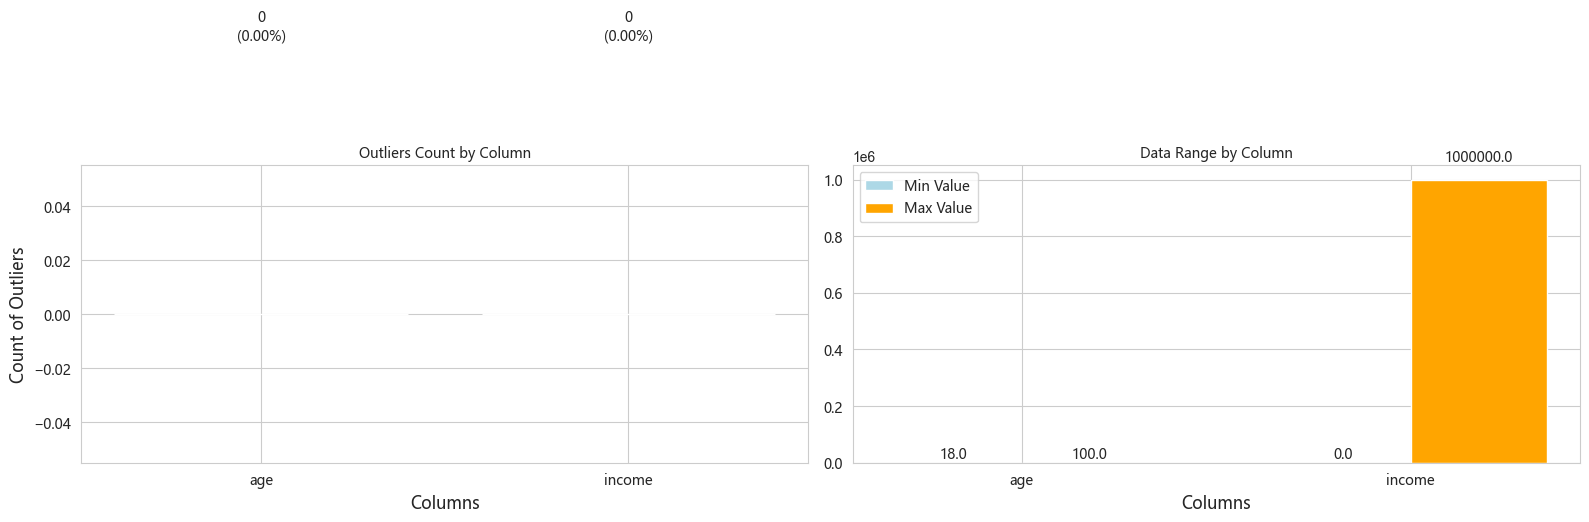


异常值统计信息:
age: 0 个异常值，占比 0.00%
    - 数值范围: 18 - 100
income: 0 个异常值，占比 0.00%
    - 数值范围: 0.0 - 1000000.0


In [21]:
# 计算异常值比例并可视化
for col in outlier_stats:
    if outlier_stats[col]['total_count'] > 0:
        outlier_stats[col]['percentage'] = (outlier_stats[col]['outlier_count'] / outlier_stats[col]['total_count']) * 100
    else:
        outlier_stats[col]['percentage'] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. 异常值数量和比例条形图
cols = list(outlier_stats.keys())
outlier_counts = [outlier_stats[col]['outlier_count'] for col in cols]
outlier_percentages = [outlier_stats[col]['percentage'] for col in cols]

bars = ax1.bar(cols, outlier_counts, color='salmon')
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{outlier_counts[i]:,}\n({outlier_percentages[i]:.2f}%)',
            ha='center', va='bottom', fontproperties=font_prop)

ax1.set_title('Outliers Count by Column', fontsize=14, fontproperties=font_prop)
ax1.set_xlabel('Columns', fontsize=12, fontproperties=font_prop)
ax1.set_ylabel('Count of Outliers', fontsize=12, fontproperties=font_prop)

for label in ax1.get_xticklabels():
    label.set_fontproperties(font_prop)
for label in ax1.get_yticklabels():
    label.set_fontproperties(font_prop)

# 2. 各属性数值范围
min_values = [outlier_stats[col]['min'] for col in cols]
max_values = [outlier_stats[col]['max'] for col in cols]

ax2.set_title('Data Range by Column', fontsize=14, fontproperties=font_prop)
ax2.set_xlabel('Columns', fontsize=12, fontproperties=font_prop)

x = np.arange(len(cols))
width = 0.35

bars1 = ax2.bar(x - width/2, min_values, width, label='Min Value', color='lightblue')
bars2 = ax2.bar(x + width/2, max_values, width, label='Max Value', color='orange')

ax2.set_xticks(x)
ax2.set_xticklabels(cols)
ax2.legend(prop=font_prop)

for label in ax2.get_xticklabels():
    label.set_fontproperties(font_prop)
for label in ax2.get_yticklabels():
    label.set_fontproperties(font_prop)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.05, 
             f'{min_values[i]:.1f}', ha='center', va='bottom', fontproperties=font_prop)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height * 1.05, 
             f'{max_values[i]:.1f}', ha='center', va='bottom', fontproperties=font_prop)

plt.tight_layout()
plt.show()

print("\n异常值统计信息:")
for col in outlier_stats:
    print(f"{col}: {outlier_stats[col]['outlier_count']:,} 个异常值，占比 {outlier_stats[col]['percentage']:.2f}%")
    print(f"    - 数值范围: {outlier_stats[col]['min']} - {outlier_stats[col]['max']}")


## 1.4. 识别潜在高价值用户

### 1.4.1. 定义、识别高价值用户

这里从收入、年龄两个维度来定义高价值用户：
* 收入(income) - 位于前25%的高收入群体
* 年龄(age) - 在25-60岁之间的经济活跃人群

基于以下假设：
* 高收入人群通常有更强的消费能力
* 25-60岁的人群通常是经济决策的主力军

In [22]:
%%time
# 定义高价值用户标准
income_data = []
high_value_users_by_age = defaultdict(int)
high_value_users_by_country = defaultdict(int)
total_users = 0
high_value_users = 0


# 确定收入阈值（全局25%分位数）
for i, file in enumerate(parquet_files):
    print(f"处理文件 {i+1}/{len(parquet_files)}: {file.name}")
    df = pd.read_parquet(file, columns=['income'])
    valid_income = df['income'].dropna()
    valid_income = valid_income[valid_income > 0]
    income_data.extend(valid_income.tolist())
    
    del df
    gc.collect()

income_threshold = np.percentile(income_data, 75)
print(f"收入阈值（前25%）: {income_threshold}")

del income_data
gc.collect()

处理文件 1/16: part-00000.parquet
处理文件 2/16: part-00001.parquet
处理文件 3/16: part-00002.parquet
处理文件 4/16: part-00003.parquet
处理文件 5/16: part-00004.parquet
处理文件 6/16: part-00005.parquet
处理文件 7/16: part-00006.parquet
处理文件 8/16: part-00007.parquet
处理文件 9/16: part-00008.parquet
处理文件 10/16: part-00009.parquet
处理文件 11/16: part-00010.parquet
处理文件 12/16: part-00011.parquet
处理文件 13/16: part-00012.parquet
处理文件 14/16: part-00013.parquet
处理文件 15/16: part-00014.parquet
处理文件 16/16: part-00015.parquet
收入阈值（前25%）: 750047.37
CPU times: total: 25.3 s
Wall time: 24.1 s


0

In [23]:
# 识别高价值用户并收集统计数据(年龄、国家)
for i, file in enumerate(parquet_files):
    print(f"处理文件 {i+1}/{len(parquet_files)}: {file.name}")
    df = pd.read_parquet(file, columns=['income', 'age', 'country'])
    file_total = len(df)
    total_users += file_total
    
    high_value_mask = (
        (df['income'] >= income_threshold) & 
        (df['age'] >= 25) & 
        (df['age'] <= 60)
    )
    
    high_value_df = df[high_value_mask]
    file_high_value = len(high_value_df)
    high_value_users += file_high_value
    
    print(f"  文件中的高价值用户: {file_high_value}/{file_total} ({file_high_value/file_total*100:.2f}%)")
    
    age_counts = high_value_df['age'].value_counts().to_dict()
    for age, count in age_counts.items():
        high_value_users_by_age[age] += count
    
    country_counts = high_value_df['country'].value_counts().to_dict()
    for country, count in country_counts.items():
        high_value_users_by_country[country] += count
    
    del df, high_value_df
    gc.collect()

print(f"\n总体高价值用户: {high_value_users}/{total_users} ({high_value_users/total_users*100:.2f}%)")

处理文件 1/16: part-00000.parquet
  文件中的高价值用户: 913626/8437500 (10.83%)
处理文件 2/16: part-00001.parquet
  文件中的高价值用户: 914552/8437500 (10.84%)
处理文件 3/16: part-00002.parquet
  文件中的高价值用户: 915965/8437500 (10.86%)
处理文件 4/16: part-00003.parquet
  文件中的高价值用户: 915174/8437500 (10.85%)
处理文件 5/16: part-00004.parquet
  文件中的高价值用户: 915062/8437500 (10.85%)
处理文件 6/16: part-00005.parquet
  文件中的高价值用户: 915606/8437500 (10.85%)
处理文件 7/16: part-00006.parquet
  文件中的高价值用户: 915001/8437500 (10.84%)
处理文件 8/16: part-00007.parquet
  文件中的高价值用户: 914071/8437500 (10.83%)
处理文件 9/16: part-00008.parquet
  文件中的高价值用户: 914658/8437500 (10.84%)
处理文件 10/16: part-00009.parquet
  文件中的高价值用户: 914404/8437500 (10.84%)
处理文件 11/16: part-00010.parquet
  文件中的高价值用户: 914076/8437500 (10.83%)
处理文件 12/16: part-00011.parquet
  文件中的高价值用户: 914151/8437500 (10.83%)
处理文件 13/16: part-00012.parquet
  文件中的高价值用户: 914909/8437500 (10.84%)
处理文件 14/16: part-00013.parquet
  文件中的高价值用户: 914382/8437500 (10.84%)
处理文件 15/16: part-00014.parquet
  文件中的高价值用户: 914176/843750

### 1.4.2. 高价值用户分析

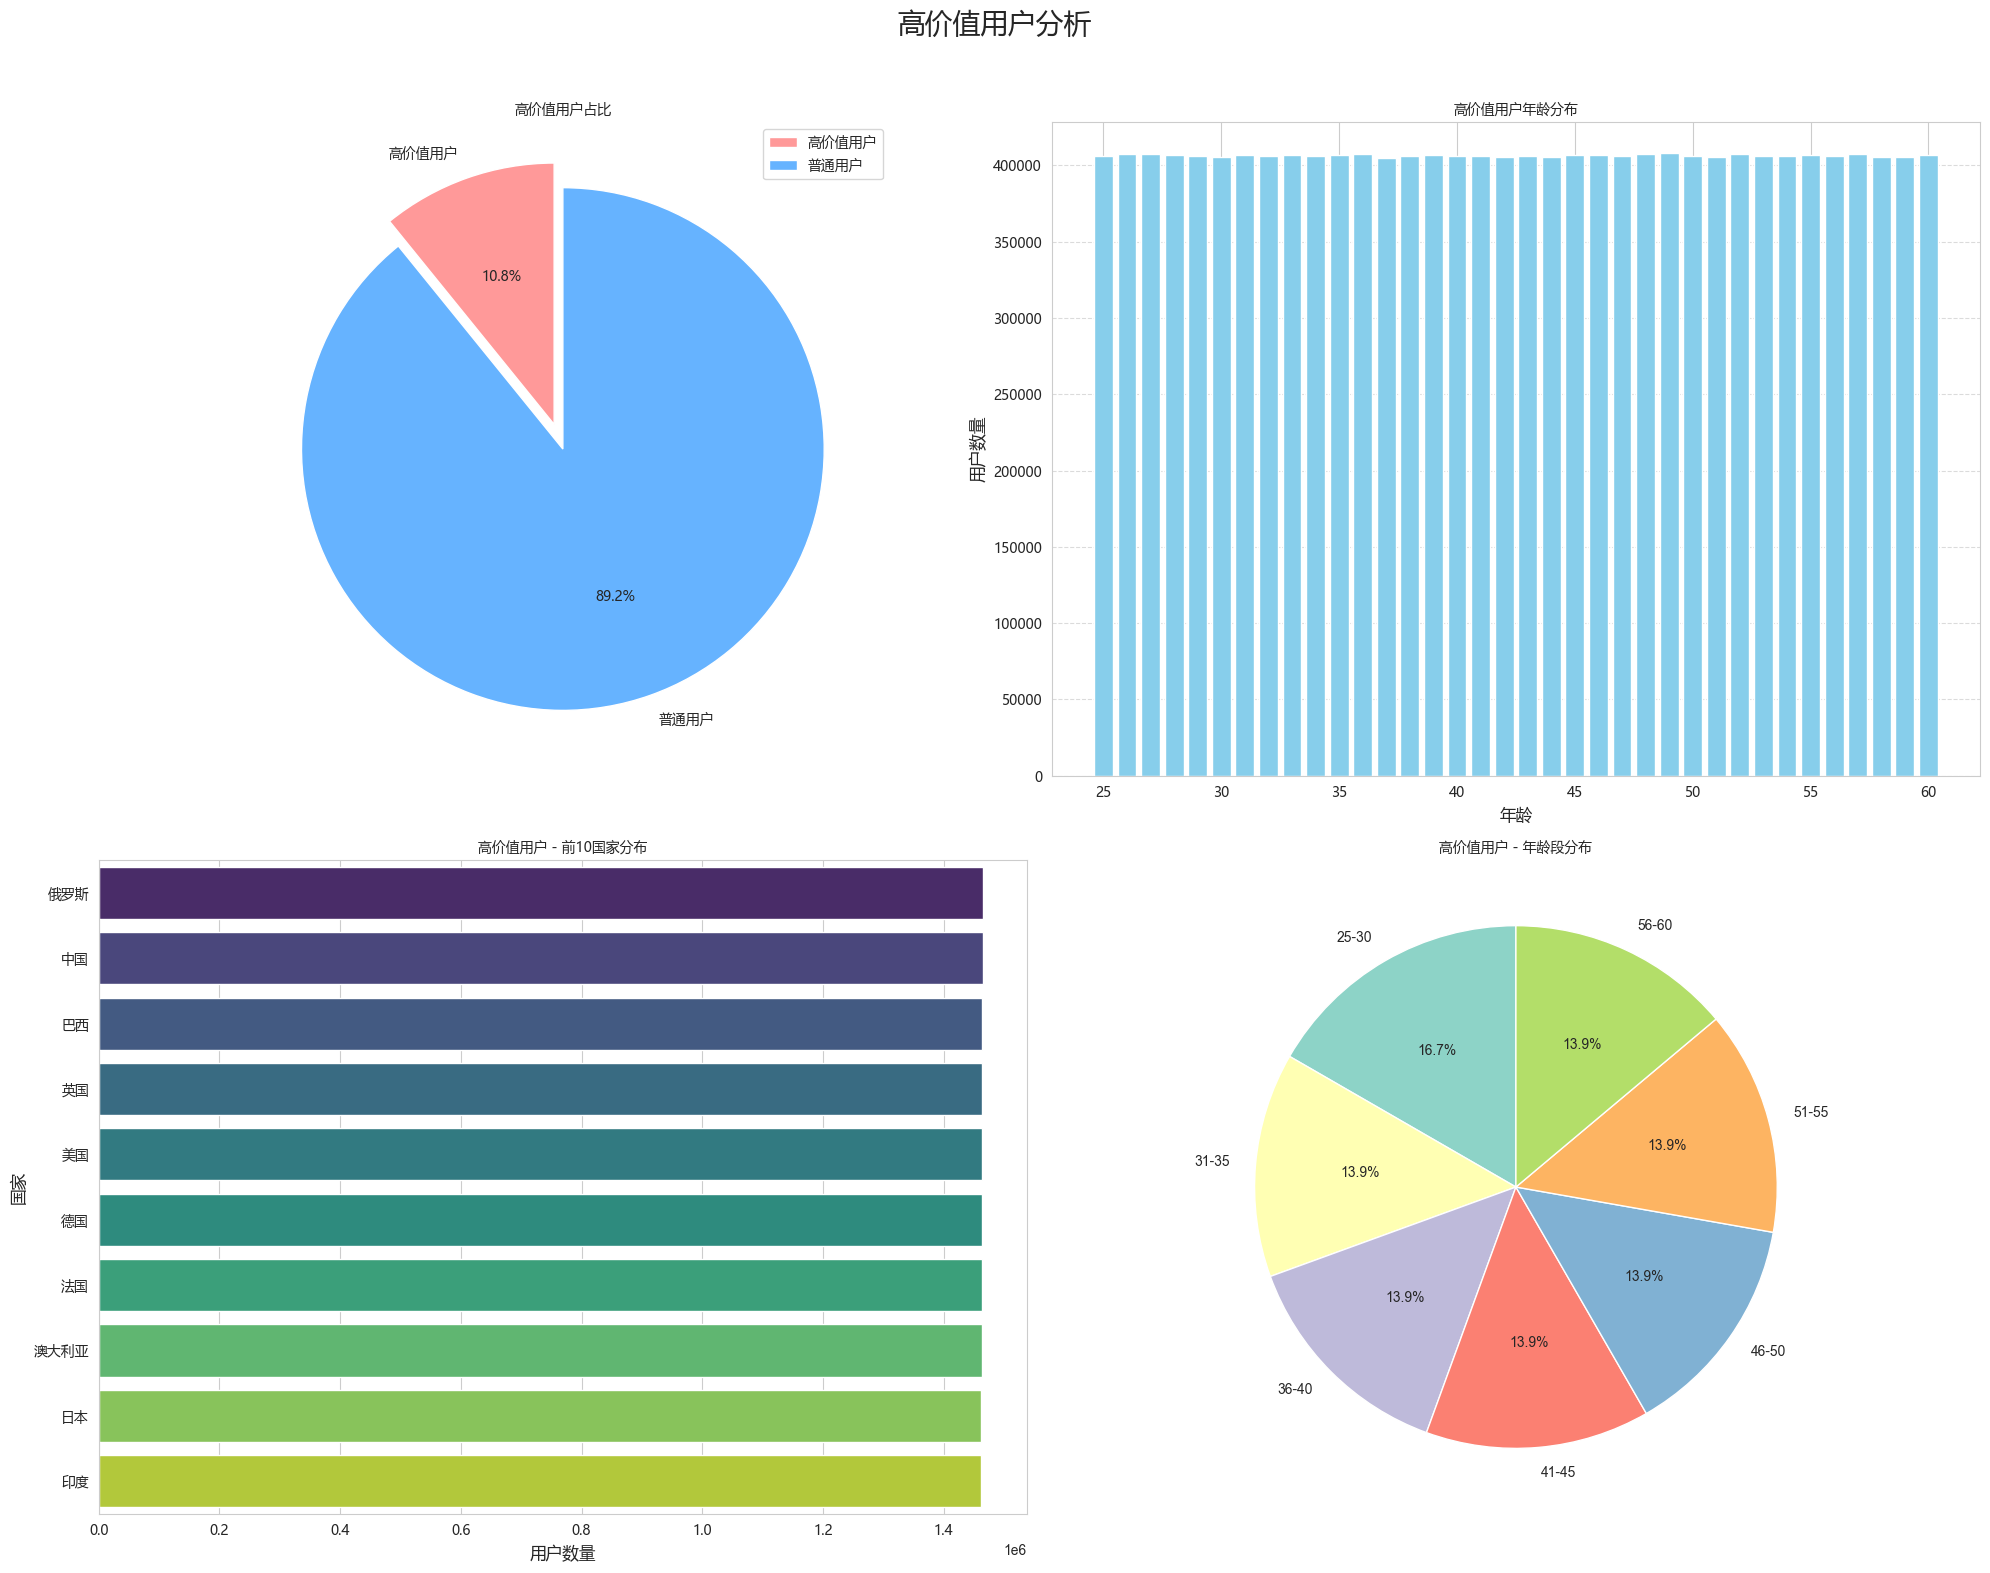

In [26]:
# 可视化高价值用户分析
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('高价值用户分析', fontsize=20, fontproperties=font_prop)

# 高价值用户占比饼图
axs[0, 0].pie(
    [high_value_users, total_users - high_value_users], 
    labels=['高价值用户', '普通用户'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff'],
    explode=(0.1, 0)
)
axs[0, 0].set_title('高价值用户占比', fontsize=16, fontproperties=font_prop)
for text in axs[0, 0].texts:
    text.set_fontproperties(font_prop)
axs[0, 0].legend(prop=font_prop)

# 高价值用户年龄分布
age_df = pd.DataFrame({
    'Age': list(high_value_users_by_age.keys()),
    'Count': list(high_value_users_by_age.values())
})
age_df = age_df.sort_values('Age')

axs[0, 1].bar(age_df['Age'], age_df['Count'], color='skyblue')
axs[0, 1].set_title('高价值用户年龄分布', fontsize=16, fontproperties=font_prop)
axs[0, 1].set_xlabel('年龄', fontsize=12, fontproperties=font_prop)
axs[0, 1].set_ylabel('用户数量', fontsize=12, fontproperties=font_prop)
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# 前10个国家的高价值用户分布
top_countries = dict(sorted(high_value_users_by_country.items(), key=lambda x: x[1], reverse=True)[:10])
country_df = pd.DataFrame({
    'Country': list(top_countries.keys()),
    'Count': list(top_countries.values())
})

sns.barplot(x='Count', y='Country', data=country_df, palette='viridis', ax=axs[1, 0])
axs[1, 0].set_title('高价值用户 - 前10国家分布', fontsize=16, fontproperties=font_prop)
axs[1, 0].set_xlabel('用户数量', fontsize=12, fontproperties=font_prop)
axs[1, 0].set_ylabel('国家', fontsize=12, fontproperties=font_prop)

# 高价值用户年龄段分布
age_groups = {
    '25-30': 0, '31-35': 0, '36-40': 0, '41-45': 0,
    '46-50': 0, '51-55': 0, '56-60': 0
}

for age, count in high_value_users_by_age.items():
    if 25 <= age <= 30:
        age_groups['25-30'] += count
    elif 31 <= age <= 35:
        age_groups['31-35'] += count
    elif 36 <= age <= 40:
        age_groups['36-40'] += count
    elif 41 <= age <= 45:
        age_groups['41-45'] += count
    elif 46 <= age <= 50:
        age_groups['46-50'] += count
    elif 51 <= age <= 55:
        age_groups['51-55'] += count
    elif 56 <= age <= 60:
        age_groups['56-60'] += count

age_group_df = pd.DataFrame({
    'Age Group': list(age_groups.keys()),
    'Count': list(age_groups.values())
})

axs[1, 1].pie(
    age_group_df['Count'],
    labels=age_group_df['Age Group'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set3', len(age_groups))
)
axs[1, 1].set_title('高价值用户 - 年龄段分布', fontsize=16, fontproperties=font_prop)

for ax in axs.flat:
    for label in ax.get_xticklabels():
        label.set_fontproperties(font_prop)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('high_value_users_analysis.png', dpi=300, bbox_inches='tight')
plt.show()